# 第三屆百日馬拉松 期末專案

### --- 專案結束後你可以學會:
1. 如何讀取並處理圖形資料
2. 使用 train / valid data 來了解深度學習模型的訓練情形
3. 了解影像辨識擴充訓練資料的 Image Data Generator 用法
4. 調整深度學習模型的超參數來提升準確率
5. 知道預訓練模型在影像辨識的威力
6. 清楚的說明文件讓別人了解你的成果

In [1]:
#keras.backend.clear_session()

import keras
from tensorflow.python.keras.applications.nasnet import NASNetLarge
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout,Input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam, Nadam, Adadelta, Adagrad, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd 
import numpy as np
import random
import shutil
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.
C:\Users\moren\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\moren\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\moren\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\moren\AppData\Roa

In [2]:
## 讀取並處理圖形資料
#資料路徑
DATASET_PATH  = 'C:/image_data'

# 影像類別數
NUM_CLASSES = 5

## 設定網路: 知道預訓練模型在影像辨識的威力
IMAGE_WIDTH=299
IMAGE_HEIGHT=IMAGE_WIDTH
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

net = Xception(include_top=False, weights='imagenet', pooling='avg',
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
output_layer = Dense(NUM_CLASSES, activation='softmax', name='output')(x)
net_final = Model(inputs=net.input, outputs=output_layer,name='x_pretrain')

FREEZE_LAYERS = 2
if FREEZE_LAYERS == -1 :
    for layer in net_final.layers:
        layer.trainable = False
else:
    for layer in net_final.layers[:FREEZE_LAYERS]:
        layer.trainable = False

    for layer in net_final.layers[FREEZE_LAYERS:]:
        layer.trainable = True       

In [6]:
## 調整深度學習模型的超參數來提升準確率
# Batch & Epoch
BATCH_SIZE = 16
FAST_RUN = False
NUM_EPOCHS = 1 if FAST_RUN else 20

# 儲存最佳結果與設定學習速率計畫
filepath="improve-{epoch:02d}-{val_acc:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
pa = 5
earlystop = EarlyStopping(monitor = "val_loss", patience = pa,verbose = 1 )
reduce_lr = ReduceLROnPlateau(factor = 0.1,min_lr = 1e-5, monitor = 'val_loss', patience = pa, verbose = 1)
callbacks = [reduce_lr, checkpoint]

# 使用優化器
net_final.compile(optimizer = SGD(lr=1e-2, decay=0.0001/50, momentum=0.9, nesterov=True),loss='binary_crossentropy', metrics=['acc'])
#net_final.compile(optimizer = Nadam(lr=1e-2),loss='binary_crossentropy', metrics=['acc'])
#net_final.compile(optimizer = Adagrad(lr=0.01), loss='binary_crossentropy', metrics=['acc'])
                  
# 輸出網路結構
print(net_final.summary())


Model: "x_pretrain"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_________________________________________________________________________________________

In [7]:
## 使用 train / valid data 來了解深度學習模型的訓練情形
## 了解影像辨識擴充訓練資料的 Image Data Generator 用法

train_datagen = ImageDataGenerator(rotation_range=10,
                                   shear_range=0.05,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,                                   
                                   horizontal_flip=True,
                                   fill_mode= "constant",
                                   rescale= 1./255,
                                   vertical_flip = False,
                                   zca_whitening = True,
                                   featurewise_center=True,  
                                   samplewise_center=True, 
                                   featurewise_std_normalization=True, 
                                   samplewise_std_normalization=True)

train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation = "bicubic",
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(rotation_range=10,
                                   shear_range=0.05,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,                                   
                                   horizontal_flip=True,
                                   fill_mode= "constant",
                                   rescale= 1./255,
                                   vertical_flip = False,
                                   zca_whitening = True,
                                   featurewise_center=True,  
                                   samplewise_center=True, 
                                   featurewise_std_normalization=True, 
                                   samplewise_std_normalization=True)

valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation ="bicubic",
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)
# 輸出類別標題
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples * 3 // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        callbacks=callbacks,
                        epochs = NUM_EPOCHS)

D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2323 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
435/435 [==============================] - 276s 636ms/step - loss: 0.1275 - acc: 0.9517 - val_loss: 0.0525 - val_acc: 0.9730

Epoch 00001: val_acc improved from -inf to 0.97298, saving model to improve-01-0.97298.hdf5
Epoch 2/20
435/435 [==============================] - 276s 635ms/step - loss: 0.0355 - acc: 0.9888 - val_loss: 0.0173 - val_acc: 0.9731

Epoch 00002: val_acc improved from 0.97298 to 0.97314, saving model to improve-02-0.97314.hdf5
Epoch 3/20
435/435 [==============================] - 274s 630ms/step - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0093 - val_acc: 0.9752

Epoch 00003: val_acc improved from 0.97314 to 0.97521, saving model to improve-03-0.97521.hdf5
Epoch 4/20
435/435 [==============================] - 275s 631ms/step - loss: 0.0109 - acc: 0.9969 - val_loss: 0.0042 - val_acc: 0.9777

Epoch 00004: val_acc improved from 0.97521 to 0.97769, saving model to improve-04-0.97769.hdf5
Epoch 5/20
435/435 [==============================] - 275s 631ms/step - los

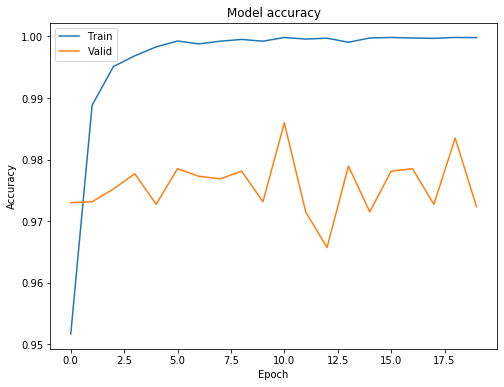

Average train accuracy: 0.996173
Average validation accuracy: 0.975715


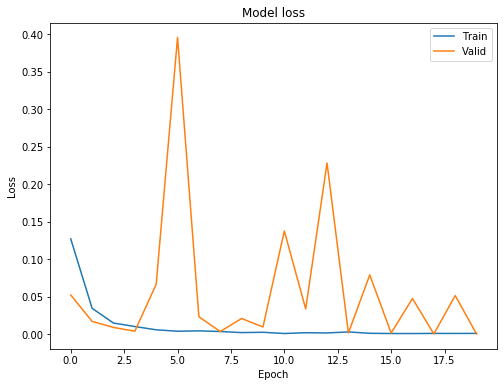

Average train loss: 0.011374
Average validation loss: 0.059342


In [8]:
# 繪圖

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='best')
plt.show()         

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [9]:
import keras
from keras.models import load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tqdm import tqdm

In [10]:
# 儲存訓練好的模型
#net_final.save_weights("weights.best.h5")
#net_final.save(DATASET_PATH + '/x_Adagrad3b.h5')

In [11]:
# 載入訓練好的模型
net = load_model('improve-11-0.98595.hdf5')
#net_final.load_weights("weights.best.h5")
#net = load_model(DATASET_PATH +'/x_Adagrad3b.h5')

In [12]:
#測試資料預處裡設定圖形產生器
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=0,
                                  zca_whitening = True,
                                  featurewise_center=True,  
                                  samplewise_center=True, 
                                  featurewise_std_normalization=True, 
                                  samplewise_std_normalization=True)

test_batches = test_datagen.flow_from_directory(DATASET_PATH +'/test',
                                                target_size = IMAGE_SIZE,
                                                interpolation = "bicubic",
                                                class_mode = 'categorical',
                                                shuffle = False,
                                                batch_size = 50)

D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2000 images belonging to 5 classes.


In [13]:
#設定儲存資料
Pred_result = pd.DataFrame(columns=['id'])

#將圖檔名稱轉換成 id 
for filename in tqdm(test_batches.filenames):
    Pred_result = Pred_result.append({'id':filename.split('\\')[1].split('.')[0]},
                                      ignore_index = True) 
#載入test data
pred = net.predict_generator(test_batches,steps=2000/50,verbose=1)
result = pd.DataFrame(pred.argsort())
Pred_result['flower_class'] = result[4]
Pred_result.head(5)   


loading id....



100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1168.02it/s]



loading test data...



D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


40/40 [==============================] - ETA: 1: - ETA: 49s - ETA: 37 - ETA: 31 - ETA: 27 - ETA: 24 - ETA: 22 - ETA: 20 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 18s 452ms/step


,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00c08828fce04e360c732cac01edad9e,4
3,00e803f7bc6d21b6d6d3a98136ea4635,2
4,00e9cb1dca407810856e77b31309d5ab,1


In [14]:
# 儲存結果
Pred_result.to_csv(DATASET_PATH+'/x_test.csv',index = False)